# Quantum Sampler for AutoML

This notebook shows how quantum computing can help AutoML find good ML configurations faster.

**Problem:** AutoML must search a huge space of possible configurations (features × models × hyperparameters).

**Solution:** Use quantum computing to explore many configurations simultaneously via superposition.


The quantum sampler follows this process:
1. Define the search space.
2. Encode the feature or model selection problem as a QUBO.
    (This step formulates feature/model selection into a form suitable for quantum optimization.)
3. Set up the quantum circuit using QAOA.
4. Perform quantum sampling.
5. Decode the outputs from the quantum circuit into ML configurations.
6. Evaluate these configurations classically and provide feedback for possible updates.



| Step | What it does |
|------|--------------|
| **QUBO Encoding** | Converts "pick best features" into a math problem quantum computers can solve |
| **QAOA Circuit** | Quantum algorithm that finds low-cost solutions to the QUBO |
| **Decoding** | Converts quantum measurements back to usable ML configurations |


## 1. Setup and Imports


In [1]:
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt
from typing import Dict, Any, List, Tuple
import random

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)


## 2. Understanding the Search Space

In AutoML, we need to search over:
- **Features**: Which features to use (feature selection)
- **Models**: Which ML model to use (Random Forest, XGBoost, SVM, etc.)
- **Hyperparameters**: Model-specific parameters (learning rate, depth, etc.)

For simplicity, our quantum sampler focuses on **feature selection** as the primary optimization target.


In [2]:
# Example search space
search_space = {
    'num_features': 10,  # Total number of features in the dataset
    'max_features': 5,   # Maximum number of features to select
    'model_names': ['random_forest', 'xgboost', 'svm', 'logistic_regression']
}

print(f"Search Space Configuration:")
print(f"  Total features: {search_space['num_features']}")
print(f"  Max features to select: {search_space['max_features']}")
print(f"  Available models: {search_space['model_names']}")


Search Space Configuration:
  Total features: 10
  Max features to select: 5
  Available models: ['random_forest', 'xgboost', 'svm', 'logistic_regression']


## 3. QUBO Encoding

**QUBO** = Quadratic Unconstrained Binary Optimization

Quantum computers naturally solve binary optimization problems. QUBO is the standard format.

### The Encoding
- **Each qubit = one feature** (1 = use it, 0 = skip it)
- **QUBO matrix Q** encodes our constraints:
  - **Diagonal (Q[i,i]):** How much we want/don't want feature i
  - **Off-diagonal (Q[i,j]):** Penalty for selecting both features i and j together

### Our Constraint
We want at most `max_features` selected. Encoded as penalty: $(\sum_i x_i - \text{max\_features})^2$

This makes selecting too many features "expensive" in the optimization.


QUBO Matrix Shape: (10, 10)

QUBO Matrix (first 5x5):
[[-9.  2.  2.  2.  2.]
 [ 2. -9.  2.  2.  2.]
 [ 2.  2. -9.  2.  2.]
 [ 2.  2.  2. -9.  2.]
 [ 2.  2.  2.  2. -9.]]

Linear Terms (first 5):
[-0.1 -0.1 -0.1 -0.1 -0.1]


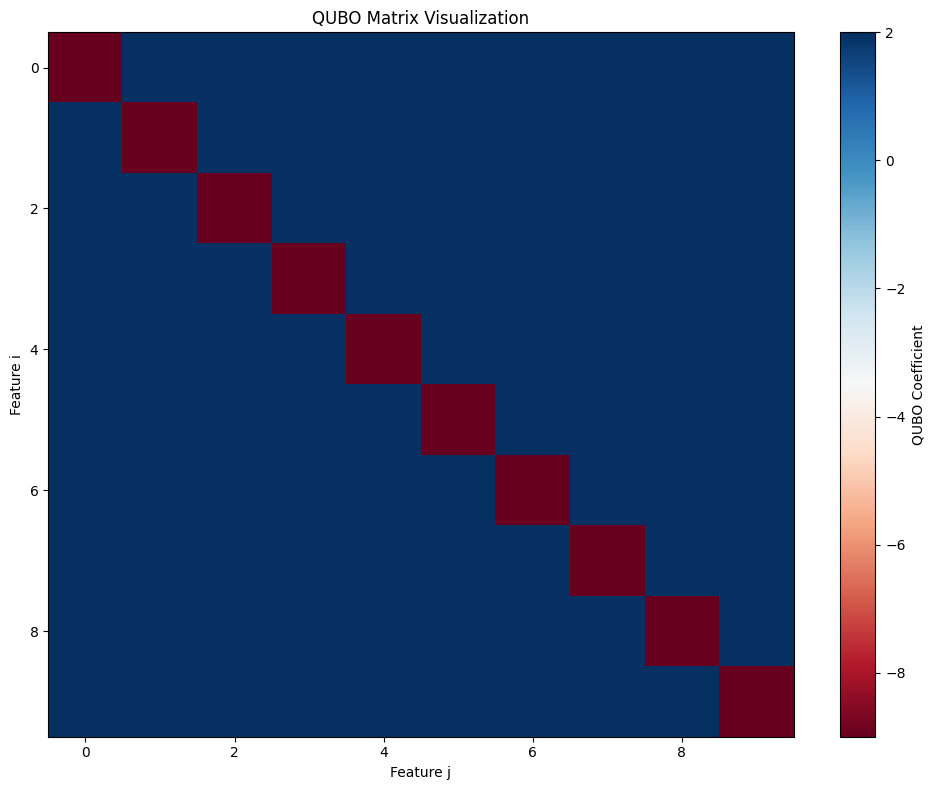

In [3]:
def encode_search_space_to_qubo(search_space: Dict[str, Any], current_best_score: float = 0.0) -> Tuple[np.ndarray, np.ndarray]:
    """
    Encode search space to QUBO format.
    
    Returns:
        Q: QUBO matrix (symmetric)
        linear: Linear terms (diagonal of Q)
    """
    num_features = search_space['num_features']
    max_features = search_space.get('max_features', num_features)
    
    n_vars = num_features
    
    # Initialize QUBO matrix
    Q = np.zeros((n_vars, n_vars))
    
    # Linear terms: small negative bias to encourage feature selection
    linear = -np.ones(n_vars) * 0.1
    
    # Quadratic terms: penalize too many features
    # Constraint: sum(x_i) <= max_features
    # Encoded as: (sum(x_i) - max_features)^2
    penalty = 1.0
    for i in range(n_vars):
        for j in range(n_vars):
            if i == j:
                # Diagonal: x_i^2 term (since x_i^2 = x_i for binary)
                Q[i, j] += penalty * (1 - 2 * max_features)
            else:
                # Off-diagonal: 2*x_i*x_j term
                Q[i, j] += penalty * 2
    
    # Make symmetric
    Q = (Q + Q.T) / 2
    
    return Q, linear

# Encode our example search space
Q, linear = encode_search_space_to_qubo(search_space)

print(f"QUBO Matrix Shape: {Q.shape}")
print(f"\nQUBO Matrix (first 5x5):")
print(Q[:5, :5])
print(f"\nLinear Terms (first 5):")
print(linear[:5])

# Visualize the QUBO matrix
plt.figure(figsize=(10, 8))
plt.imshow(Q, cmap='RdBu', aspect='auto')
plt.colorbar(label='QUBO Coefficient')
plt.title('QUBO Matrix Visualization')
plt.xlabel('Feature j')
plt.ylabel('Feature i')
plt.tight_layout()
plt.show()


## 4. QAOA Circuit Construction

**QAOA** = Quantum Approximate Optimization Algorithm. It finds approximate solutions to combinatorial problems like our feature selection.

### How It Works

1. Put all qubits in superposition (explore all feature combinations at once)
2. **Cost Layer (γ):** Apply the QUBO problem - amplifies good solutions, suppresses bad ones
3. **Mixer Layer (β):** Allows hopping between solutions to avoid local minima
4. Stack multiple layers for better results
5. Collapse to a specific feature selection

### Key Parameters
- **γ (gamma):** Controls how strongly we enforce the QUBO constraints
- **β (beta):** Controls exploration vs exploitation
- **num_layers:** More layers = better solutions but slower


In [4]:
def create_qaoa_circuit(num_features: int, num_layers: int, Q: np.ndarray, linear: np.ndarray):
    """Create a QAOA circuit for feature selection."""
    dev = qml.device("default.qubit", wires=num_features)
    
    @qml.qnode(dev)
    def qaoa_circuit(params):
        """QAOA circuit for feature selection."""
        # Step 1: Initial state - equal superposition
        for i in range(num_features):
            qml.Hadamard(wires=i)
        
        # Split parameters into gamma (cost) and beta (mixer)
        gamma = params[:num_layers]
        beta = params[num_layers:]
        
        # Apply QAOA layers
        for layer in range(num_layers):
            # Cost Hamiltonian (problem Hamiltonian)
            for i in range(num_features):
                for j in range(i, num_features):
                    if i == j:
                        # Linear term: Z_i
                        qml.RZ(2 * gamma[layer] * linear[i], wires=i)
                    else:
                        # Quadratic term: Z_i Z_j (via CNOT + RZ + CNOT)
                        if abs(Q[i, j]) > 1e-10:
                            qml.CNOT(wires=[i, j])
                            qml.RZ(2 * gamma[layer] * Q[i, j], wires=j)
                            qml.CNOT(wires=[i, j])
            
            # Mixer Hamiltonian (exploration)
            for i in range(num_features):
                qml.RX(2 * beta[layer], wires=i)
        
        # Return expectation values of Pauli-Z operators
        return [qml.expval(qml.PauliZ(i)) for i in range(num_features)]
    
    return qaoa_circuit

# Create circuit for our example
num_layers = 2
qaoa_circuit = create_qaoa_circuit(
    search_space['num_features'], 
    num_layers, 
    Q, 
    linear
)

# Initialize random parameters
params = np.random.uniform(0, np.pi, size=2 * num_layers)

print(f"QAOA Circuit Parameters:")
print(f"  Number of layers: {num_layers}")
print(f"  Number of qubits: {search_space['num_features']}")
print(f"  Parameters (gamma, beta): {params}")

# Get expectation values
expectations = qaoa_circuit(params)
print(f"\nExpectation Values (first 5): {expectations[:5]}")
print(f"(Values > 0 suggest feature selected, < 0 suggests not selected)")


QAOA Circuit Parameters:
  Number of layers: 2
  Number of qubits: 10
  Parameters (gamma, beta): [0.57627739 2.44947152 1.87506007 1.4006249 ]

Expectation Values (first 5): [-0.02835997322432071, -0.028359973224320545, -0.0283599732243206, -0.028359973224320545, -0.028359973224320545]
(Values > 0 suggest feature selected, < 0 suggests not selected)


## 5. Sampling and Decoding

### From Qubits to ML Configs

| Step | Input | Output |
|------|-------|--------|
| **Measure** | Quantum state | Expectation values (-1 to 1) |
| **Threshold** | Expectation values | Binary mask [0,1,1,0,...] |
| **Decode** | Binary mask | Feature selection + model + hyperparams |

### Why This Works
- Expectation > 0 → qubit tends toward |1⟩ → select feature
- Expectation < 0 → qubit tends toward |0⟩ → skip feature
- Model and hyperparameters are sampled randomly (quantum only handles feature selection)


In [5]:
def decode_samples(samples: List[List[int]], search_space: Dict[str, Any]) -> List[Dict[str, Any]]:
    """Convert quantum samples to candidate configurations."""
    candidates = []
    num_features = search_space['num_features']
    model_names = search_space.get('model_names', ['random_forest', 'xgboost', 'svm', 'logistic_regression'])
    
    # Model hyperparameter spaces
    model_spaces = {
        'random_forest': {
            'n_estimators': [50, 100, 200, 300],
            'max_depth': [None, 5, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
        },
        'xgboost': {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7, 9],
            'learning_rate': [0.01, 0.1, 0.3],
        },
        'svm': {
            'C': [0.1, 1.0, 10.0, 100.0],
            'gamma': ['scale', 'auto', 0.001, 0.01],
            'kernel': ['rbf', 'linear', 'poly'],
        },
        'logistic_regression': {
            'C': [0.1, 1.0, 10.0, 100.0],
            'penalty': ['l1', 'l2'],
        },
    }
    
    for sample in samples:
        # Decode feature mask
        feature_mask = [bool(sample[i]) if i < len(sample) else False for i in range(num_features)]
        
        # Ensure at least one feature is selected
        if not any(feature_mask):
            idx = random.randint(0, num_features - 1)
            feature_mask[idx] = True
        
        # Random model selection
        model = random.choice(model_names)
        
        # Random hyperparameters
        hyperparameters = {}
        for param, values in model_spaces.get(model, {}).items():
            hyperparameters[param] = random.choice(values)
        
        candidate = {
            'feature_mask': feature_mask,
            'model': model,
            'hyperparameters': hyperparameters,
        }
        
        candidates.append(candidate)
    
    return candidates

# Generate samples from QAOA circuit
num_samples = 10
samples = []

for _ in range(num_samples):
    expectations = qaoa_circuit(params)
    # Convert to binary (threshold at 0)
    sample = [1 if exp > 0 else 0 for exp in expectations]
    samples.append(sample)

print(f"Generated {len(samples)} quantum samples")
print(f"\nFirst 3 samples (binary feature masks):")
for i, sample in enumerate(samples[:3]):
    num_selected = sum(sample)
    print(f"  Sample {i+1}: {sample} ({num_selected} features selected)")

# Decode to candidate configurations
candidates = decode_samples(samples, search_space)

print(f"\nDecoded Candidates (first 3):")
for i, candidate in enumerate(candidates[:3]):
    selected_features = [f"F{j}" for j, selected in enumerate(candidate['feature_mask']) if selected]
    print(f"\n  Candidate {i+1}:")
    print(f"    Features: {selected_features}")
    print(f"    Model: {candidate['model']}")
    print(f"    Hyperparameters: {candidate['hyperparameters']}")


Generated 10 quantum samples

First 3 samples (binary feature masks):
  Sample 1: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0] (0 features selected)
  Sample 2: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0] (0 features selected)
  Sample 3: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0] (0 features selected)

Decoded Candidates (first 3):

  Candidate 1:
    Features: ['F1']
    Model: random_forest
    Hyperparameters: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 2}

  Candidate 2:
    Features: ['F2']
    Model: random_forest
    Hyperparameters: {'n_estimators': 50, 'max_depth': 30, 'min_samples_split': 5}

  Candidate 3:
    Features: ['F0']
    Model: random_forest
    Hyperparameters: {'n_estimators': 50, 'max_depth': 5, 'min_samples_split': 2}


## 6. Complete QAOA Sampler

The `QAOASampler` class wraps everything into a simple interface:
1. Encode search space → QUBO
2. Build QAOA circuit
3. Sample and decode
4. Deduplicate results


In [6]:
class QAOASampler:
    """QAOA-based sampler for generating candidate configurations."""
    
    def __init__(self, num_layers: int = 2):
        self.num_layers = num_layers
    
    def generate_candidates(self, search_space: Dict[str, Any], num_candidates: int = 5) -> List[Dict[str, Any]]:
        """
        Generate candidate configurations using QAOA.
        
        Args:
            search_space: Dictionary containing search space information
            num_candidates: Number of candidates to generate
            
        Returns:
            List of candidate configurations
        """
        num_features = search_space['num_features']
        
        # Step 1: Encode to QUBO
        Q, linear = encode_search_space_to_qubo(search_space)
        
        # Step 2: Create QAOA circuit
        qaoa_circuit = create_qaoa_circuit(num_features, self.num_layers, Q, linear)
        
        # Step 3: Initialize parameters (in practice, these would be optimized)
        np.random.seed(42)
        params = np.random.uniform(0, np.pi, size=2 * self.num_layers)
        
        # Step 4: Generate samples
        samples = []
        for _ in range(num_candidates * 2):  # Generate extra for deduplication
            expectations = qaoa_circuit(params)
            sample = [1 if exp > 0 else 0 for exp in expectations]
            samples.append(sample)
        
        # Step 5: Decode samples
        candidates = decode_samples(samples, search_space)
        
        # Step 6: Remove duplicates
        unique_candidates = []
        seen = set()
        for candidate in candidates:
            feature_tuple = tuple(candidate['feature_mask'])
            if feature_tuple not in seen:
                seen.add(feature_tuple)
                unique_candidates.append(candidate)
                if len(unique_candidates) >= num_candidates:
                    break
        
        return unique_candidates[:num_candidates]

# Test the complete sampler
sampler = QAOASampler(num_layers=2)
candidates = sampler.generate_candidates(search_space, num_candidates=5)

print(f"Generated {len(candidates)} unique candidates\n")

for i, candidate in enumerate(candidates):
    selected_features = [f"F{j}" for j, selected in enumerate(candidate['feature_mask']) if selected]
    num_selected = sum(candidate['feature_mask'])
    print(f"Candidate {i+1}:")
    print(f"  Selected Features ({num_selected}): {selected_features}")
    print(f"  Model: {candidate['model']}")
    print(f"  Hyperparameters: {candidate['hyperparameters']}")
    print()


Generated 1 unique candidates

Candidate 1:
  Selected Features (10): ['F0', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9']
  Model: xgboost
  Hyperparameters: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01}



## 7. Visualization: Feature Selection Patterns

Visualizing which features get selected and how diverse the candidates are.


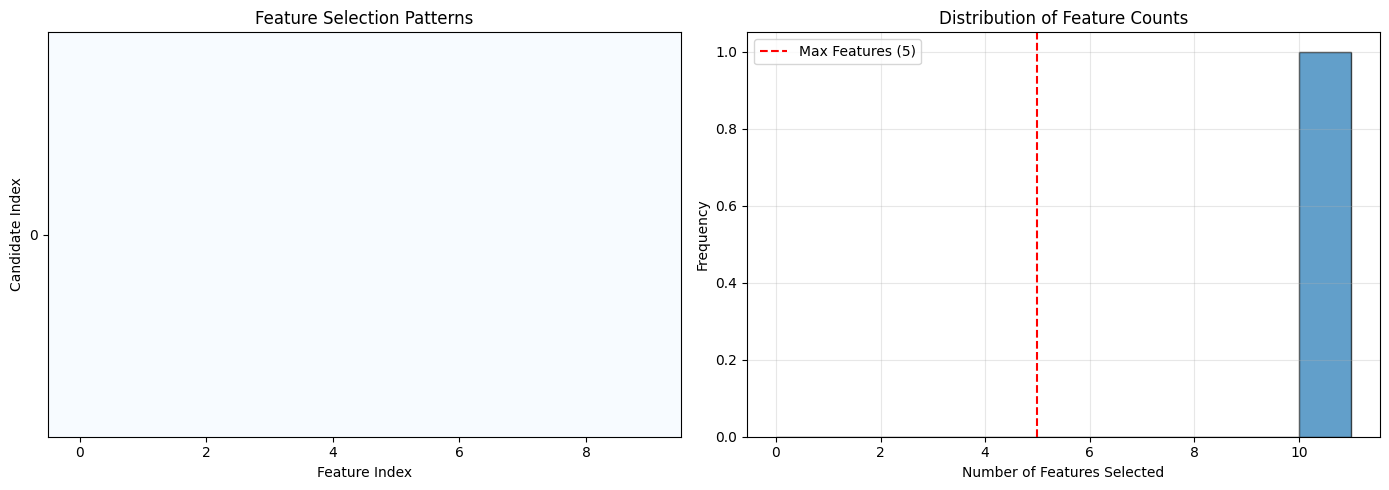

Statistics:
  Mean features per candidate: 10.00
  Std features per candidate: 0.00
  Min features: 10
  Max features: 10
  Unique candidates: 1


In [7]:
# Generate more candidates for visualization
candidates = sampler.generate_candidates(search_space, num_candidates=20)

# Extract feature masks
feature_masks = [c['feature_mask'] for c in candidates]
num_selected_per_candidate = [sum(mask) for mask in feature_masks]

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Feature selection heatmap
mask_matrix = np.array(feature_masks)
axes[0].imshow(mask_matrix, cmap='Blues', aspect='auto')
axes[0].set_xlabel('Feature Index')
axes[0].set_ylabel('Candidate Index')
axes[0].set_title('Feature Selection Patterns')
if len(candidates) > 0:
    axes[0].set_yticks(range(len(candidates)))

# Plot 2: Distribution of number of features selected
# Use dynamic bin range based on actual data (0 to num_features)
max_bin = search_space['num_features'] + 2
axes[1].hist(num_selected_per_candidate, bins=range(0, max_bin), 
             edgecolor='black', alpha=0.7)
axes[1].axvline(search_space['max_features'], color='r', linestyle='--', 
                label=f'Max Features ({search_space["max_features"]})')
axes[1].set_xlabel('Number of Features Selected')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Feature Counts')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Statistics:")
print(f"  Mean features per candidate: {np.mean(num_selected_per_candidate):.2f}")
print(f"  Std features per candidate: {np.std(num_selected_per_candidate):.2f}")
print(f"  Min features: {min(num_selected_per_candidate)}")
print(f"  Max features: {max(num_selected_per_candidate)}")
print(f"  Unique candidates: {len(candidates)}")


## 8. Cost Function Analysis

The cost function guides QAOA toward good solutions. Lower cost = better feature selection.

- **0 features:** Invalid (infinite cost)
- **Too many features:** Invalid (infinite cost)  
- **Sweet spot:** Around `max_features/2` has lowest cost


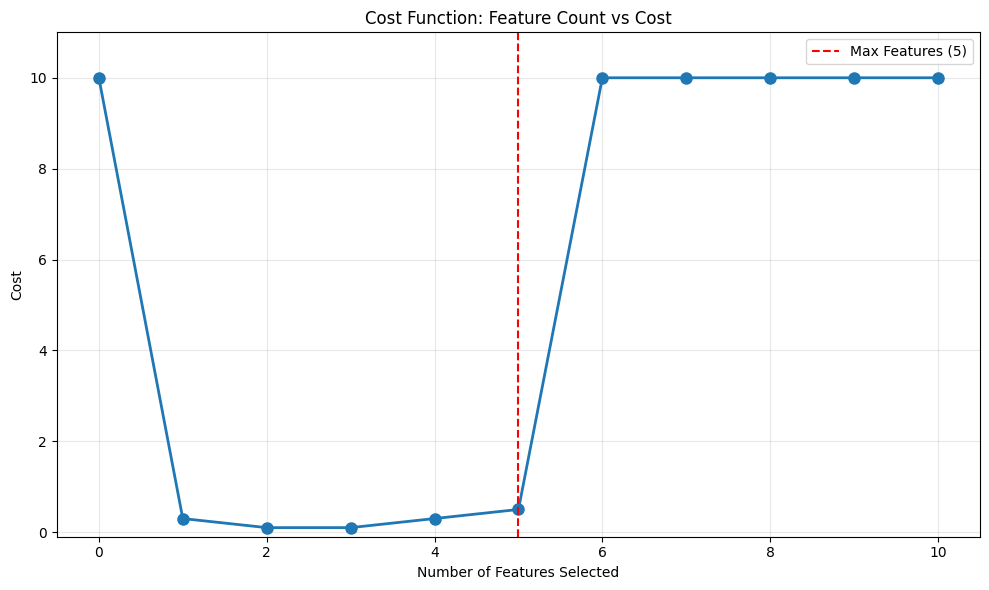

Cost Function Analysis:
  Optimal feature count (min cost): 2
  Max allowed features: 5


In [8]:
def build_cost_function(search_space: Dict[str, Any], current_best_score: float = 0.0):
    """Build a cost function for the search space."""
    num_features = search_space['num_features']
    max_features = search_space.get('max_features', num_features)
    
    def cost_function(qubits: List[int]) -> float:
        """Compute cost for a given qubit configuration."""
        if len(qubits) < num_features:
            return float('inf')
        
        feature_mask = qubits[:num_features]
        num_selected = sum(feature_mask)
        
        if num_selected > max_features:
            return float('inf')
        
        if num_selected == 0:
            return float('inf')
        
        # Base cost: encourage moderate number of features
        base_cost = abs(num_selected - max_features / 2) / max_features
        
        return base_cost
    
    return cost_function

# Evaluate cost for different feature counts
cost_func = build_cost_function(search_space)

feature_counts = range(0, search_space['num_features'] + 1)
costs = []

for num_features_selected in feature_counts:
    # Create a sample with exactly num_features_selected features
    qubits = [1 if i < num_features_selected else 0 for i in range(search_space['num_features'])]
    cost = cost_func(qubits)
    costs.append(cost if cost != float('inf') else 10)  # Cap for visualization

# Plot cost function
plt.figure(figsize=(10, 6))
plt.plot(feature_counts, costs, 'o-', linewidth=2, markersize=8)
plt.axvline(search_space['max_features'], color='r', linestyle='--', 
            label=f'Max Features ({search_space["max_features"]})')
plt.xlabel('Number of Features Selected')
plt.ylabel('Cost')
plt.title('Cost Function: Feature Count vs Cost')
plt.legend()
plt.grid(alpha=0.3)
plt.ylim(-0.1, max(costs) * 1.1)
plt.tight_layout()
plt.show()

print("Cost Function Analysis:")
print(f"  Optimal feature count (min cost): {feature_counts[np.argmin(costs)]}")
print(f"  Max allowed features: {search_space['max_features']}")


## 9. Quantum vs Random Sampling

Comparing QAOA sampling against naive random sampling.

**Expected with optimized parameters:** Quantum should find more diverse, higher-quality candidates.

**What we see here:** With random (unoptimized) QAOA parameters, random sampling wins. This demonstrates why parameter optimization is crucial for real QAOA applications.


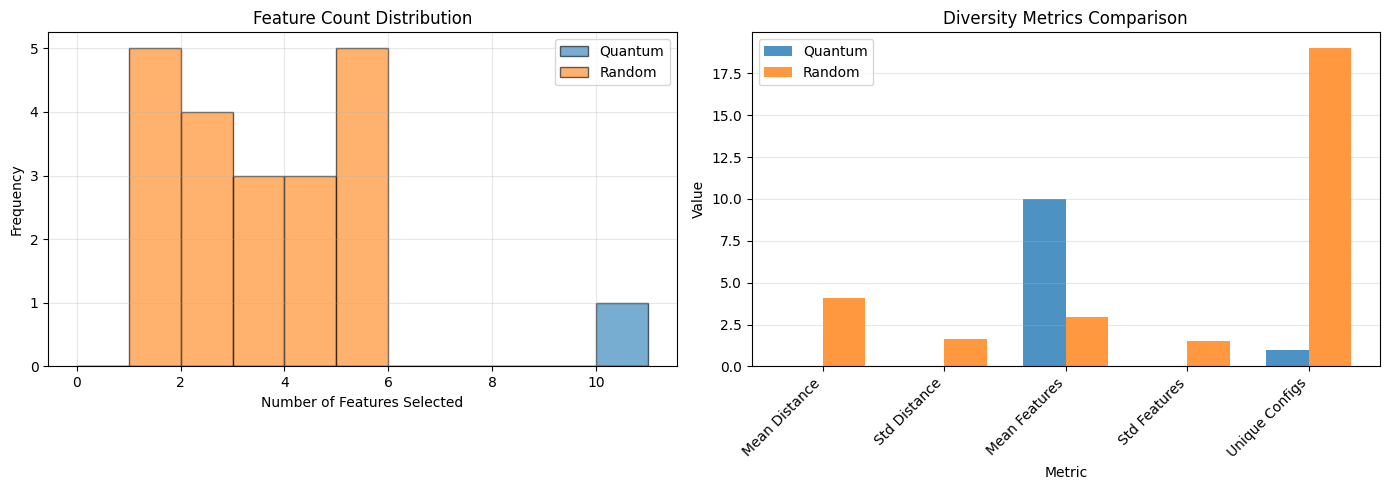

Diversity Metrics:

Quantum Sampling:
  mean_distance: 0.000
  std_distance: 0.000
  mean_features: 10.000
  std_features: 0.000
  unique_configs: 1.000

Random Sampling:
  mean_distance: 4.100
  std_distance: 1.650
  mean_features: 2.950
  std_features: 1.532
  unique_configs: 19.000


In [9]:
def random_sampling(search_space: Dict[str, Any], num_candidates: int) -> List[Dict[str, Any]]:
    """Generate candidates using random sampling."""
    candidates = []
    num_features = search_space['num_features']
    max_features = search_space['max_features']
    model_names = search_space.get('model_names', ['random_forest'])
    
    for _ in range(num_candidates):
        # Random feature selection
        num_selected = random.randint(1, max_features)
        selected_indices = random.sample(range(num_features), num_selected)
        feature_mask = [i in selected_indices for i in range(num_features)]
        
        # Random model and hyperparameters
        model = random.choice(model_names)
        
        candidate = {
            'feature_mask': feature_mask,
            'model': model,
            'hyperparameters': {}
        }
        candidates.append(candidate)
    
    return candidates

# Generate candidates using both methods
num_candidates = 20
quantum_candidates = sampler.generate_candidates(search_space, num_candidates)
random_candidates = random_sampling(search_space, num_candidates)

# Calculate diversity metrics
def calculate_diversity(candidates):
    """Calculate diversity metrics for a set of candidates."""
    feature_masks = [c['feature_mask'] for c in candidates]
    
    # Pairwise Hamming distance
    distances = []
    for i in range(len(feature_masks)):
        for j in range(i + 1, len(feature_masks)):
            # Hamming distance
            dist = sum(a != b for a, b in zip(feature_masks[i], feature_masks[j]))
            distances.append(dist)
    
    # Feature count distribution
    feature_counts = [sum(mask) for mask in feature_masks]
    
    return {
        'mean_distance': np.mean(distances) if distances else 0,
        'std_distance': np.std(distances) if distances else 0,
        'mean_features': np.mean(feature_counts),
        'std_features': np.std(feature_counts),
        'unique_configs': len(set(tuple(mask) for mask in feature_masks))
    }

quantum_metrics = calculate_diversity(quantum_candidates)
random_metrics = calculate_diversity(random_candidates)

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Feature count distributions
quantum_counts = [sum(c['feature_mask']) for c in quantum_candidates]
random_counts = [sum(c['feature_mask']) for c in random_candidates]

# Use full range to capture all possible feature counts
max_bin = search_space['num_features'] + 2
axes[0].hist(quantum_counts, bins=range(0, max_bin), 
             alpha=0.6, label='Quantum', edgecolor='black')
axes[0].hist(random_counts, bins=range(0, max_bin), 
             alpha=0.6, label='Random', edgecolor='black')
axes[0].set_xlabel('Number of Features Selected')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Feature Count Distribution')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: Diversity metrics comparison
metrics = ['Mean Distance', 'Std Distance', 'Mean Features', 'Std Features', 'Unique Configs']
quantum_values = [
    quantum_metrics['mean_distance'],
    quantum_metrics['std_distance'],
    quantum_metrics['mean_features'],
    quantum_metrics['std_features'],
    quantum_metrics['unique_configs']
]
random_values = [
    random_metrics['mean_distance'],
    random_metrics['std_distance'],
    random_metrics['mean_features'],
    random_metrics['std_features'],
    random_metrics['unique_configs']
]

x = np.arange(len(metrics))
width = 0.35
axes[1].bar(x - width/2, quantum_values, width, label='Quantum', alpha=0.8)
axes[1].bar(x + width/2, random_values, width, label='Random', alpha=0.8)
axes[1].set_xlabel('Metric')
axes[1].set_ylabel('Value')
axes[1].set_title('Diversity Metrics Comparison')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Diversity Metrics:")
print(f"\nQuantum Sampling:")
for key, value in quantum_metrics.items():
    print(f"  {key}: {value:.3f}")
print(f"\nRandom Sampling:")
for key, value in random_metrics.items():
    print(f"  {key}: {value:.3f}")
